In [3]:
#!/usr/bin/env python3
import importlib
import matching
import reconstruction
import bundle_adjustment
import utilis

importlib.reload(matching)
importlib.reload(reconstruction)
importlib.reload(bundle_adjustment)
importlib.reload(utilis)

from matching import FeatureMatcher, MatchConfig
from reconstruction import Reconstruction, ReconstructionCfg
from bundle_adjustment import BundleAdjuster, BAConfig
from utilis import *

# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("SFM")

In [4]:
# ----------------------------------------------------------------------------
# 1) CONFIGURATION & SETUP
# ----------------------------------------------------------------------------


# dataset_path = './datasets/House'
# dataset_path = './datasets/park_gate'
# dataset_path = './datasets/templeRing'
dataset_path = './datasets/lego_block' # Make sure to recalibrate if using this dataset
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
ext = rename_images_sequentially(dataset_path, valid_extensions=valid_extensions)


# After renaming, use this pattern to load them
img_pattern = f"{{idx:02d}}{ext}"
print(f"Image pattern: {img_pattern}")

output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

reprojection_errors = []
points_history = []

# Get list of image filenames after renaming
image_files = get_image_files(dataset_path, ext=ext)
n_imgs = len(image_files)
logger.info(f"Found {n_imgs} images in {dataset_path}")

# Load camera calibration matrix K
calib_path = Path(dataset_path) / 'K.txt'
K = load_calibration_matrix(calib_path)
logger.info(f"Loaded calibration matrix K:\n{K}")

# Load images
images = []
for idx in range(n_imgs):
    img_path = Path(dataset_path) / img_pattern.format(idx=idx)
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Failed to load image {img_path}")
    images.append(img)
logger.info(f"Loaded {len(images)} images.")


INFO:SFM:Found 28 images in ./datasets/lego_block
INFO:SFM:Loaded calibration matrix K:
[[2.80444051e+03 0.00000000e+00 1.98681500e+03]
 [0.00000000e+00 2.80732343e+03 1.52260165e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


✅ Done renaming images.
Image pattern: {idx:02d}.png


INFO:SFM:Loaded 28 images.


INFO:SFM:Running feature matching pipeline…
INFO:matching:Extracting features...
INFO:matching:Extracted features from 28 images.


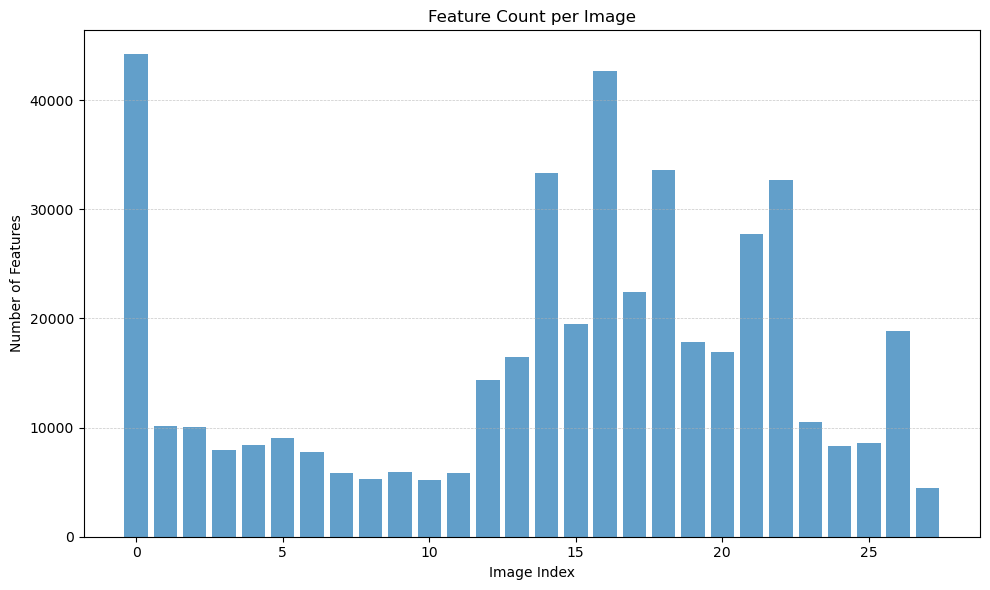

INFO:matching:Matching feature pairs...
INFO:matching:Matched 378 image pairs.
INFO:matching:Filtering matches with geometric constraints...
INFO:matching:147 pairs left after geometric verification.
INFO:matching:Best pair: (24, 25) with 2500 matches


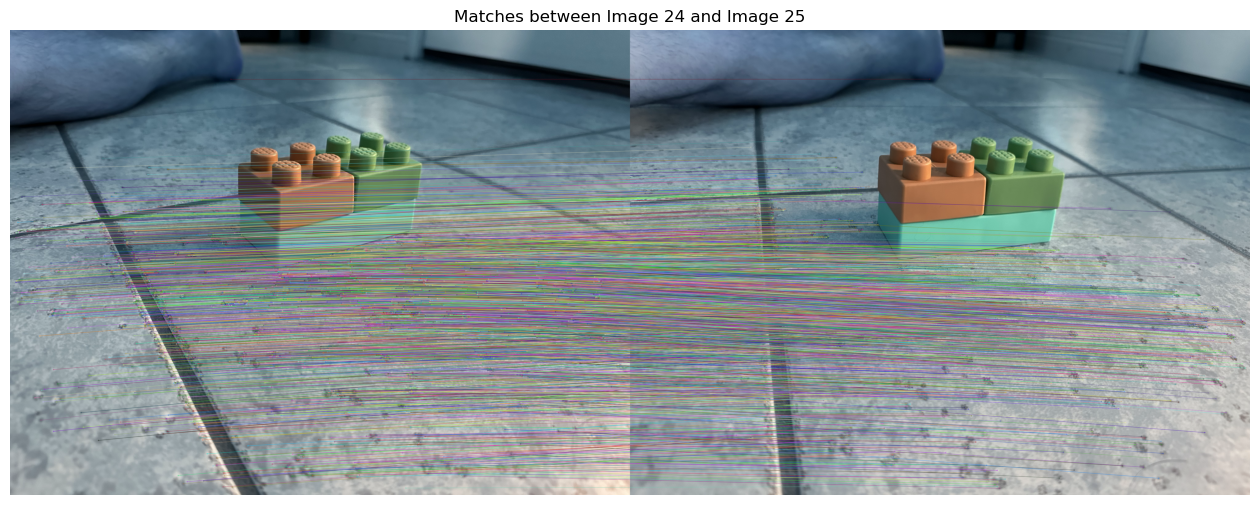

INFO:SFM:✅ Feature matching complete.


In [5]:
# ----------------------------------------------------------------------------
# 2) FEATURE MATCHING
# ----------------------------------------------------------------------------
fm_cfg = MatchConfig(
    dataset_path=dataset_path,
    img_pattern=img_pattern,
    ratio_thresh=0.75,
    ransac_thresh=3.0,
    min_inliers=20,
    use_flann=False,
    nfeatures=0  # Deafult = 0
)

logger.info("Running feature matching pipeline…")
fm = FeatureMatcher(n_imgs=n_imgs, cfg=fm_cfg)
fm.images = images  # Optionally skip reloading images
fm.extract_features()
fm.plot_feature_histogram()
fm.match_pairs()
fm.filter_geometric()
fm.plot_best_match()

# fm.run() # Or call fm.run() to do full pipeline including loading

keypoints = fm.kps
matches = fm.matches
adjacency = fm.adjacency


logger.info("✅ Feature matching complete.")

In [6]:
# ----------------------------------------------------------------------------
# 3) INCREMENTAL RECONSTRUCTION
# ----------------------------------------------------------------------------

import os
cpu_cores = os.cpu_count()
print(f"Detected {cpu_cores} CPU cores")

recon_cfg = ReconstructionCfg(
    K=K,
    min_inliers_baseline=50,
    essential_ransac_thresh=3.0,
    pnp_reproj_thresh=4.0,
    pnp_iterations=500,
    pnp_method= cv2.SOLVEPNP_ITERATIVE, #
    min_pnp_correspondences=10,
    max_failed_attempts=3,
    bundle_every=5,
    verbose=True,
    num_threads = cpu_cores #-> USE min(cpu_cores, 4)
)

recon = Reconstruction(
    keypoints=keypoints,
    matches=matches,
    img_adjacency=adjacency,
    cfg=recon_cfg,
    images=images
)

logger.info("Selecting baseline…")
baseline = recon.select_baseline(top_percent=0.25)
logger.info(f"Baseline selected: {baseline}")

try:
    recon.initialize(baseline)
except Exception as e:
    logger.error(f"Initialization failed: {e}")
    raise

pts3d_initial = [p.coords for p in recon.points3d]
logger.info(f"Starting Points: {len(pts3d_initial)}, Starting Cameras: {len(recon.poses)}")

points_history.append(len(recon.points3d))


INFO:SFM:Selecting baseline…
INFO:reconstruction:Baseline pair: (24, 25) with 2500 matches, 637500 inliers, median parallax 8.57°
INFO:SFM:Baseline selected: (24, 25)
INFO:reconstruction:Triangulating 2500 points between images 24 and 25
INFO:reconstruction:Successfully added 2500 new colored 3D points between images 24 and 25
INFO:reconstruction:Initialized reconstruction with baseline image pair.
INFO:SFM:Starting Points: 2500, Starting Cameras: 2


Detected 16 CPU cores


In [7]:
# ----------------------------------------------------------------------------
# 4) SET UP BUNDLE ADJUSTMENT
# ----------------------------------------------------------------------------

def run_ba():
    logger.info("Starting bundle adjustment…")
    cam_ids = list(recon.poses.keys())
    n_cams = len(cam_ids)

    init_rvecs = {}
    init_tvecs = {}
    for norm_i, cam in enumerate(cam_ids):
        R, t = recon.poses[cam]
        rvec, _ = cv2.Rodrigues(R)
        init_rvecs[norm_i] = rvec.ravel()
        init_tvecs[norm_i] = t.ravel().reshape(3, 1)

    pts3d_list = [p.coords for p in recon.points3d]
    n_pts = len(pts3d_list)

    cam_idx, pt_idx, pts2d = [], [], []
    for pi, p3d in enumerate(recon.points3d):
        for cam, kpt_i in p3d.observations.items():
            cam_norm = cam_ids.index(cam)
            cam_idx.append(cam_norm)
            pt_idx.append(pi)
            pts2d.append(keypoints[cam][kpt_i].pt)

    cam_idx = np.array(cam_idx)
    pt_idx = np.array(pt_idx)
    pts2d = np.array(pts2d, dtype=np.float64)

    ba_cfg = BAConfig(
        max_nfev=1500,
        ftol=1e-6,
        xtol=1e-6,
        gtol=1e-6,
        loss='huber', #Can use Cauchy, L1, Huber and more
        f_scale=1.0,
        method='trf'
    )

    ba = BundleAdjuster(K, cam_idx, pt_idx, pts2d, n_cams, n_pts,
                        init_rvecs, init_tvecs, pts3d_list, ba_cfg)

    rvecs_opt, tvecs_opt, pts3d_opt = ba.optimize()

    for norm_i, cam in enumerate(cam_ids):
        rvec = rvecs_opt[norm_i]
        tvec = tvecs_opt[norm_i]
        Ropt, _ = cv2.Rodrigues(rvec)
        recon.poses[cam] = (Ropt, tvec)

    for i, xyz in enumerate(pts3d_opt):
        recon.points3d[i].coords = xyz

    params_opt = pack_params(rvecs_opt, tvecs_opt, pts3d_opt)
    avg_error = ba.compute_average_reprojection_error(params_opt)

    reprojection_errors.append(avg_error)
    points_history.append(len(recon.points3d))


logger.info("Bundle adjustment has been set up")

INFO:SFM:Bundle adjustment has been set up


In [8]:
# ----------------------------------------------------------------------------
# 5) GROW RECONSTRUCTION WITH BUNDLE ADJUSTMENT
# ----------------------------------------------------------------------------
from tqdm.notebook import tqdm  # Better support for VSCode/Jupyter
logger.info("Growing reconstruction with live progress…")

max_attempts = 3
pbar = tqdm(total=n_imgs, desc="Images registered", dynamic_ncols=True)
pbar.update(len(recon.poses))  # Initial baseline count

last_pose_count = len(recon.poses)


while len(recon.poses) < n_imgs:
    success = False
    for attempt in range(max_attempts):
        try:
            recon.grow(bundle_adjust_fn=run_ba, pbar=pbar)
            success = True
            break
        except Exception as e:
            logger.warning(f"Reconstruction growth failed: {str(e)}. Retrying...")

    if not success:
        logger.error("Stopping growth. Failed after maximum retries.")
        break

    # If no progress was made since last iteration, stop
    if len(recon.poses) == last_pose_count:
        logger.warning("No new poses were added in this iteration. Stopping to prevent infinite loop.")
        break

    last_pose_count = len(recon.poses)

pbar.close()

INFO:SFM:Growing reconstruction with live progress…


Images registered:   0%|          | 0/28 [00:00<?, ?it/s]

INFO:reconstruction:Added image 0 with 463 PnP inliers
INFO:reconstruction:Added 1076 new colored 3D points during addition of image 0
INFO:reconstruction:Added image 26 with 362 PnP inliers
INFO:reconstruction:Added 879 new colored 3D points during addition of image 26
INFO:reconstruction:Added image 23 with 615 PnP inliers
INFO:reconstruction:Added 470 new colored 3D points during addition of image 23
INFO:reconstruction:Added image 1 with 308 PnP inliers
INFO:reconstruction:Added 599 new colored 3D points during addition of image 1
INFO:reconstruction:Added image 8 with 54 PnP inliers
INFO:reconstruction:Added 192 new colored 3D points during addition of image 8
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1043e+04                                    1.77e+06    
       1              2         4.0666e+04      3.76e+02       2.17e-04       6.33e+05    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 4.1043e+04, final cost 4.0666e+04, first-order optimality 6.33e+05.


INFO:reconstruction:Added image 9 with 64 PnP inliers
INFO:reconstruction:Added 478 new colored 3D points during addition of image 9
INFO:reconstruction:Added image 10 with 104 PnP inliers
INFO:reconstruction:Added 651 new colored 3D points during addition of image 10
INFO:reconstruction:Added image 27 with 79 PnP inliers
INFO:reconstruction:Added 300 new colored 3D points during addition of image 27
INFO:reconstruction:Added image 2 with 147 PnP inliers
INFO:reconstruction:Added 442 new colored 3D points during addition of image 2
INFO:reconstruction:Added image 7 with 73 PnP inliers
INFO:reconstruction:Added 602 new colored 3D points during addition of image 7
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0563e+05                                    3.57e+06    
       1              2         1.0251e+05      3.13e+03       1.18e-03       2.89e+06    
       2              3         1.0220e+05      3.05e+02       1.67e-04       1.11e+06    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.0563e+05, final cost 1.0220e+05, first-order optimality 1.11e+06.


INFO:reconstruction:Added image 6 with 160 PnP inliers
INFO:reconstruction:Added 966 new colored 3D points during addition of image 6
INFO:reconstruction:Added image 5 with 271 PnP inliers
INFO:reconstruction:Added 854 new colored 3D points during addition of image 5
INFO:reconstruction:Added image 16 with 62 PnP inliers
INFO:reconstruction:Added 159 new colored 3D points during addition of image 16
INFO:reconstruction:Added image 22 with 96 PnP inliers
INFO:reconstruction:Added 209 new colored 3D points during addition of image 22
INFO:reconstruction:Added image 4 with 89 PnP inliers
INFO:reconstruction:Added 422 new colored 3D points during addition of image 4
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3236e+05                                    1.36e+06    
       1              2         1.3171e+05      6.46e+02       3.34e-04       2.16e+06    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.3236e+05, final cost 1.3171e+05, first-order optimality 2.16e+06.


INFO:reconstruction:Added image 3 with 62 PnP inliers
INFO:reconstruction:Added 474 new colored 3D points during addition of image 3
INFO:reconstruction:Added image 18 with 41 PnP inliers
INFO:reconstruction:Added 226 new colored 3D points during addition of image 18
INFO:reconstruction:Added image 20 with 67 PnP inliers
INFO:reconstruction:Added 525 new colored 3D points during addition of image 20
INFO:reconstruction:Added image 19 with 407 PnP inliers
INFO:reconstruction:Added 1314 new colored 3D points during addition of image 19
INFO:reconstruction:Added image 21 with 100 PnP inliers
INFO:reconstruction:Added 247 new colored 3D points during addition of image 21
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8007e+05                                    6.52e+06    
       1              2         3.7564e+05      4.43e+03       1.15e-03       8.86e+06    
       2              3         3.7330e+05      2.34e+03       5.77e-04       5.43e+06    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 3.8007e+05, final cost 3.7330e+05, first-order optimality 5.43e+06.


INFO:reconstruction:Added image 17 with 58 PnP inliers
INFO:reconstruction:Added 259 new colored 3D points during addition of image 17
INFO:reconstruction:Added image 11 with 58 PnP inliers
INFO:reconstruction:Added 362 new colored 3D points during addition of image 11
INFO:reconstruction:Added image 12 with 32 PnP inliers
INFO:reconstruction:Added 473 new colored 3D points during addition of image 12
INFO:reconstruction:Added image 13 with 18 PnP inliers
INFO:reconstruction:Added 420 new colored 3D points during addition of image 13
INFO:reconstruction:Added image 14 with 9 PnP inliers
INFO:reconstruction:Added 253 new colored 3D points during addition of image 14
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2625e+05                                    5.44e+06    
       1              2         5.2450e+05      1.75e+03       4.29e-04       3.49e+06    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 5.2625e+05, final cost 5.2450e+05, first-order optimality 3.49e+06.


INFO:reconstruction:Added image 15 with 15 PnP inliers
INFO:reconstruction:Added 571 new colored 3D points during addition of image 15


In [9]:
# ----------------------------------------------------------------------------
# 6) FINAL BUNDLE ADJUSTMENT AND VISUALIZATION
# ----------------------------------------------------------------------------
logger.info("Running final bundle adjustment…")
run_ba()
visualize_current_state(recon, "Final Reconstruction")

INFO:SFM:Running final bundle adjustment…
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5223e+05                                    3.49e+06    


INFO:utilis:Final Reconstruction | Points: 15923, Cameras: 28


       1              2         5.5081e+05      1.42e+03       4.53e-04       3.29e+06    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 5.5223e+05, final cost 5.5081e+05, first-order optimality 3.29e+06.


In [10]:
# ----------------------------------------------------------------------------
# 7) SUMMARY LOGGING
# ----------------------------------------------------------------------------
used_images = sorted(recon.poses.keys())
total_3d_points = len(recon.points3d)
avg_error = np.mean(reprojection_errors) if reprojection_errors else -1
avg_points_per_image = total_3d_points / len(used_images) if used_images else 0

logger.info("=" * 60)
logger.info(" Structure from Motion Summary")
logger.info("=" * 60)
logger.info(f" Images used             : {len(used_images)} / {n_imgs}")
logger.info(f" Final 3D points         : {total_3d_points}")
logger.info(f" Avg reprojection error : {avg_error:.2f} pixels")
logger.info(f" Avg 3D pts per image   : {avg_points_per_image:.2f}")
logger.info("=" * 60)


INFO:SFM:============================================================
INFO:SFM: Structure from Motion Summary
INFO:SFM:============================================================
INFO:SFM: Images used             : 28 / 28
INFO:SFM: Final 3D points         : 15923
INFO:SFM: Avg reprojection error : 8.30 pixels
INFO:SFM: Avg 3D pts per image   : 568.68
INFO:SFM:============================================================


In [11]:
# ----------------------------------------------------------------------------
# 8) SAVE FINAL 3D RECONSTRUCTION
# ----------------------------------------------------------------------------
# ply_path = output_dir / "house.ply"
# ply_path = output_dir / "park_gate.ply"
# ply_path = output_dir / "templeRing.ply"
ply_path = output_dir / "lego_block.ply"
save_reconstruction_ply(recon.points3d, ply_path, camera_poses=recon.poses)

INFO:utilis:📁 Saved filtered reconstruction to: outputs/lego_block.ply


In [15]:
# ----------------------------------------------------------------------------
# 9) VISUALIZE TEMPLE RING RECONSTRUCTION IN OPEN3D
# ----------------------------------------------------------------------------
display_saved_reconstruction(str(ply_path))


In [13]:
# # ----------------------------------------------------------------------------
# # 10) VISUALIZE HOUSE RECONSTRUCTION IN OPEN3D
# # ----------------------------------------------------------------------------
# ply_path = output_dir / "reconstruction_House_cams.ply"
# display_saved_reconstruction(str(ply_path))